# Cleaning

In [1]:
import numpy as np
import pandas as pd
import os
from nltk.corpus import stopwords
import string
import datetime

In [2]:
# set up sets for cleaning
stopword = stopwords.words('english')
letters = set(string.ascii_lowercase)
digits = set(string.digits)

# clean the tweets posts
def clean_text(x):
    text = x['text'].lower().split()
    # remove retweet usernames
    if x['retweeted'] == False:
        text = text[2:]
    text = ' '.join(text)
    
    # remove punctuation
    cleaned = []
    for c in text:
        if (c in letters) or (c in digits) or (c == " "):
            cleaned.append(c)
    text = ''.join(cleaned)
    
    # remove stopwords
    result = ''
    for word in text.split():
        if word not in stopword and len(word) >= 3:
            result += word + ' '
    
    return result


# combine all in functions
def clean_csv(path, filename, topath):
    df = pd.read_csv(path+filename, usecols=range(1,9))
    df = df[df['language'] == 'en']
    df['clean_text'] = df.apply(clean_text,axis=1)
    df = df.dropna(subset=['clean_text'])
    df.to_csv(topath+filename[:10]+'-clean.csv',index=False)
    return

In [3]:
for fn in os.listdir('../data/raw'):
    if '2020' in fn:
        print(fn)
        clean_csv('../data/raw/', fn, '../data/interim/')

2020-06-17.csv
2020-10-19.csv
2020-07-05.csv
2020-05-26.csv
2020-08-28.csv
2020-07-02.csv
2020-05-21.csv
2020-06-10.csv
2020-08-26.csv
2020-11-02.csv
2020-10-10.csv
2020-06-19.csv
2020-10-17.csv
2020-03-31.csv
2020-08-21.csv
2020-05-28.csv
2020-11-05.csv
2020-10-22.csv
2020-09-06.csv
2020-08-14.csv
2020-11-30.csv
2020-08-13.csv
2020-04-08.csv
2020-10-25.csv
2020-09-01.csv
2020-05-14.csv
2020-04-06.csv
2020-06-25.csv
2020-04-01.csv
2020-06-22.csv
2020-09-08.csv
2020-05-13.csv
2020-07-30.csv
2020-09-19.csv
2020-04-10.csv
2020-07-21.csv
2020-05-02.csv
2020-07-26.csv
2020-11-28.csv
2020-05-05.csv
2020-04-17.csv
2020-07-28.csv
2020-11-26.csv
2020-08-02.csv
2020-09-10.csv
2020-04-19.csv
2020-09-17.csv
2020-11-21.csv
2020-08-05.csv
2020-09-22.csv
2020-10-06.csv
2020-06-08.csv
2020-11-14.csv
2020-08-30.csv
2020-11-13.csv
2020-09-25.csv
2020-10-01.csv
2020-03-27.csv
2020-05-30.csv
2020-07-13.csv
2020-03-29.csv
2020-04-22.csv
2020-06-01.csv
2020-10-08.csv
2020-04-25.csv
2020-06-06.csv
2020-07-14

In [11]:
def total_case(path, filename, tofilename, topath, sdate, edate):
    # set up start date and end date
    start_date = datetime.datetime.strptime(sdate, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(edate, '%Y-%m-%d')
    
    # read and clean dataset
    df_case = pd.read_csv(path+filename)
    df_case['date'] = pd.to_datetime(df_case['date'], format='%Y-%m-%d')
    
    # filter out dates
    df_case = df_case[(df_case['date'] >= start_date) & (df_case['date'] < end_date)]
    df_case_sum = df_case[['date', 'new_cases']].groupby(by=['date']).sum().reset_index()
    df_case_sum.to_csv(topath+tofilename,index=False)

In [12]:
total_case('../data/raw/', 'owid-covid-data.csv', 'new_cases.csv', '../data/interim/', '2020-03-22', '2020-12-01')

In [4]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url, error_bad_lines=False)
len(df['location'].unique())

200

# Analysis

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [7]:
def draw_wordcloud(freq, topath, tofilename):
    wc = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(freq)
    fig = plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis('off')
    fig.savefig(topath+tofilename)
    return

In [8]:
def compute_freq(df, vectorizer, topath, tofilename):
    vec = vectorizer.set_params(**{'max_features':100})
    doc_vec = vec.fit_transform(df['text'].values.astype('U'))
    df_dtm = pd.DataFrame(doc_vec.toarray(), columns=vec.get_feature_names())
    df_freq = df_dtm.sum().sort_values(ascending=False)
    df_freq.to_csv(topath+tofilename, header=False)

In [3]:
# read data
df = pd.DataFrame({'date':[], 'text':[]})
for fn in os.listdir('../data/interim/'):
    if 'clean' in fn:
        df_temp = pd.read_csv('../data/interim/{}'.format(fn),lineterminator='\n')
        text = list(df_temp['clean_text'].to_numpy())
        date = [fn[:10]] * len(text)
        df_temp = pd.DataFrame({'date':date, 'text':text})
        df = df.append(df_temp, ignore_index=True)
# drop nan
df = df.dropna(subset=['text'])
df = df.reset_index(drop=True)

In [19]:
# negative
print(sum(df['text'].apply(lambda x: 'sad' in x)))
print(sum(df['text'].apply(lambda x: 'deaths' in x)))
print(sum(df['text'].apply(lambda x: 'sick' in x)))

5173
34822
6087


In [20]:
# positive
print(sum(df['text'].apply(lambda x: 'great' in x)))
print(sum(df['text'].apply(lambda x: 'happy' in x)))
print(sum(df['text'].apply(lambda x: 'success' in x)))

11746
2457
3596


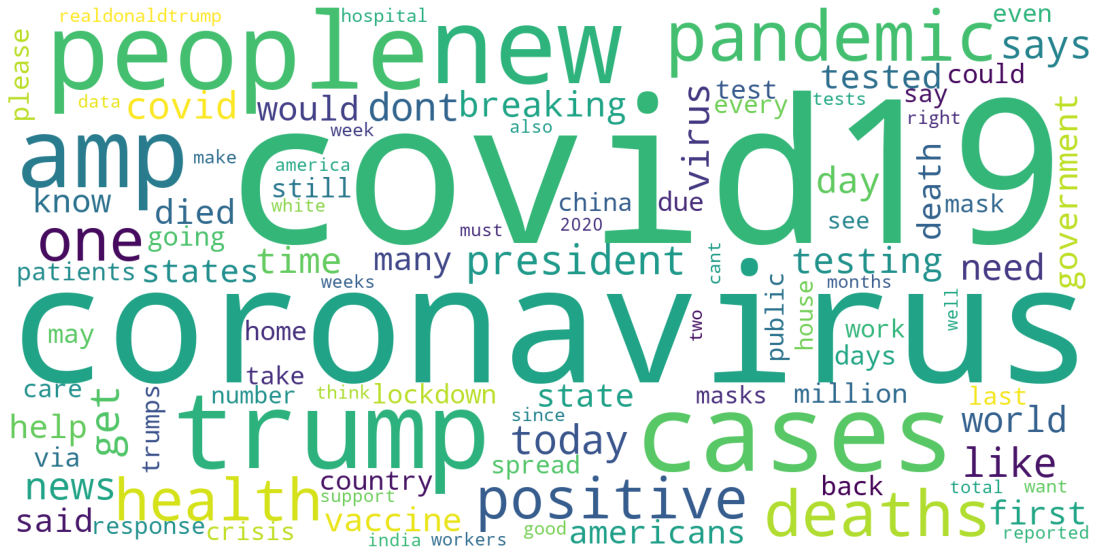

In [26]:
vec = CountVectorizer(max_features=100)
doc_vec = vec.fit_transform(df['text'].values.astype('U'))
df_dtm = pd.DataFrame(doc_vec.toarray(), columns=vec.get_feature_names())
df_freq = df_dtm.sum().sort_values(ascending=False)

wc = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(df_freq)
fig = plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

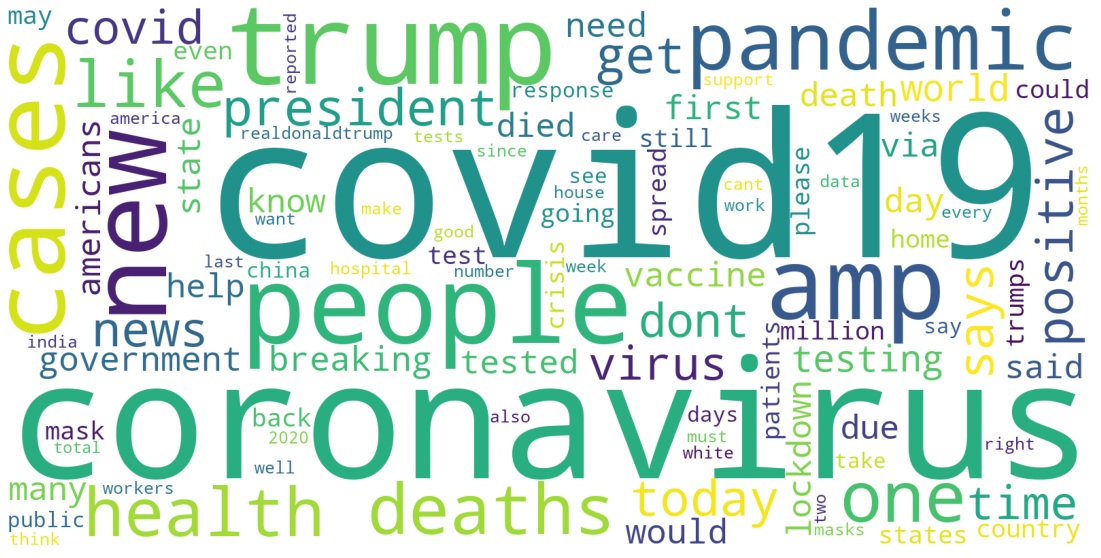

In [4]:
vec = TfidfVectorizer(max_features=100)
doc_vec = vec.fit_transform(df['text'].values.astype('U'))
df_dtm = pd.DataFrame(doc_vec.toarray(), columns=vec.get_feature_names())
df_freq = df_dtm.sum().sort_values(ascending=False)

wc = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(df_freq)
fig = plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

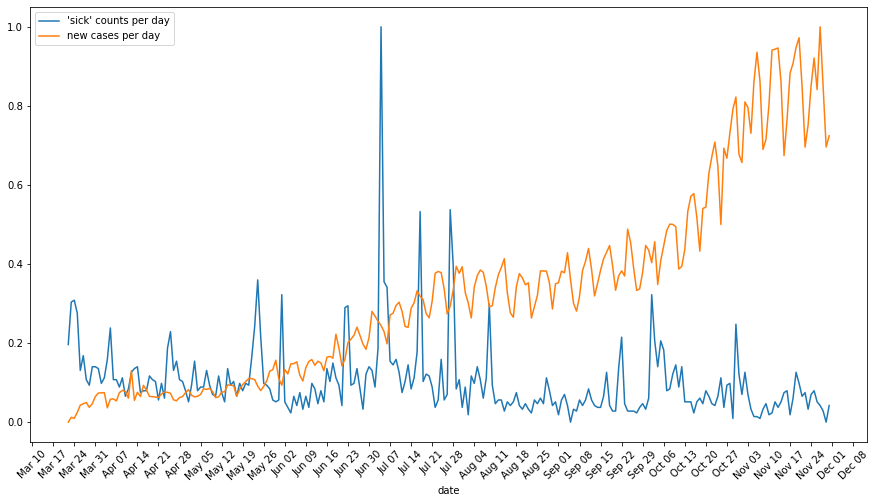

In [24]:
# read data
df_word = df[df['text'].apply(lambda x: 'sick' in x)]
df_word = df_word.groupby('date').count().reset_index()
df_word['date'] = pd.to_datetime(df_word['date'])
df_case = pd.read_csv('../data/interim/new_cases.csv',parse_dates=['date'])

# normalize data
df_word_cnt = (df_word['text'] - df_word['text'].min()) / (df_word['text'].max() - df_word['text'].min())
df_case_cnt = (df_case['new_cases'] - df_case['new_cases'].min()) / (df_case['new_cases'].max() - df_case['new_cases'].min())

# plot
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_word['date'], df_word_cnt, label="'{}' counts per day".format('sick'))
ax.plot(df_case['date'], df_case_cnt, label='new cases per day')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend()
plt.xlabel('date')
plt.xticks(rotation=45)
plt.show()

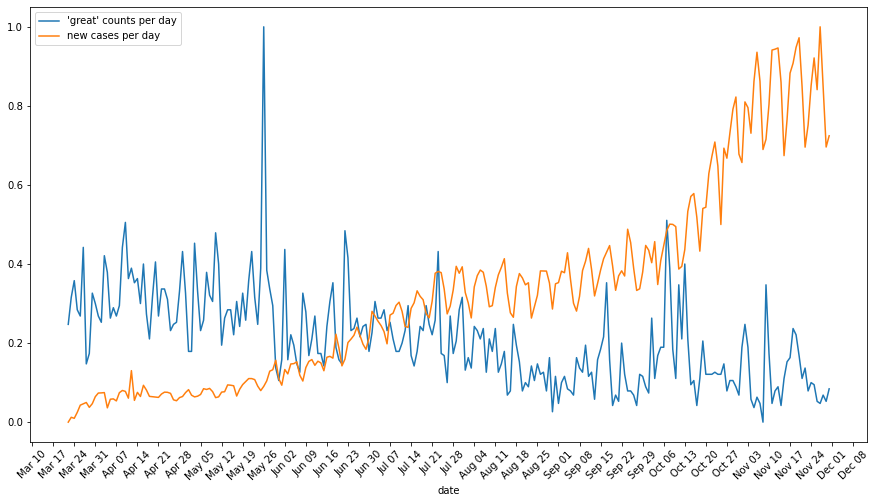

In [22]:
# read data
df_word = df[df['text'].apply(lambda x: 'great' in x)]
df_word = df_word.groupby('date').count().reset_index()
df_word['date'] = pd.to_datetime(df_word['date'])
df_case = pd.read_csv('../data/interim/new_cases.csv',parse_dates=['date'])

# normalize data
df_word_cnt = (df_word['text'] - df_word['text'].min()) / (df_word['text'].max() - df_word['text'].min())
df_case_cnt = (df_case['new_cases'] - df_case['new_cases'].min()) / (df_case['new_cases'].max() - df_case['new_cases'].min())

# plot
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_word['date'], df_word_cnt, label="'{}' counts per day".format('great'))
ax.plot(df_case['date'], df_case_cnt, label='new cases per day')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend()
plt.xlabel('date')
plt.xticks(rotation=45)
plt.show()

In [5]:
def gen_date_list(start_str, end_str):
    """Generate the date list in string format of 
    2020-01-01
    used to read in all the csv documents
    """
    start = datetime.datetime.strptime(start_str, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_str, "%Y-%m-%d")
    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    date_list = []
    for date in date_generated:
        date_list.append(date.strftime("%Y-%m-%d"))
    return date_list

In [31]:
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import datetime

date_list = gen_date_list('2020-03-22', '2020-12-01')
sid = SentimentIntensityAnalyzer()
pol = sid.polarity_scores
score_list = []
test_df = pd.read_csv('../data/interim/' + '2020-03-25' + '-clean.csv',lineterminator='\n')
test_df['clean_text'].apply(lambda x: pol(str(x)))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/yut085/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0       {'neg': 0.151, 'neu': 0.849, 'pos': 0.0, 'comp...
1       {'neg': 0.572, 'neu': 0.36, 'pos': 0.068, 'com...
2       {'neg': 0.147, 'neu': 0.853, 'pos': 0.0, 'comp...
3       {'neg': 0.0, 'neu': 0.19, 'pos': 0.81, 'compou...
4       {'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'comp...
                              ...                        
5426    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5427    {'neg': 0.0, 'neu': 0.391, 'pos': 0.609, 'comp...
5428    {'neg': 0.203, 'neu': 0.677, 'pos': 0.12, 'com...
5429    {'neg': 0.623, 'neu': 0.377, 'pos': 0.0, 'comp...
5430    {'neg': 0.51, 'neu': 0.49, 'pos': 0.0, 'compou...
Name: clean_text, Length: 5431, dtype: object

In [32]:
pd.read_csv('../data/interim/new_cases.csv')

,date,new_cases
0,2020-03-22,69662.0
1,2020-03-23,85702.0
2,2020-03-24,82320.0
3,2020-03-25,102036.0
4,2020-03-26,125660.0
...,...,...
249,2020-11-26,1165420.0
250,2020-11-27,1372580.0
251,2020-11-28,1172982.0
252,2020-11-29,976416.0
